In [19]:
import pandas as pd
import numpy as np

In [2]:
%cd ..

/Users/koloss/Desktop/STATS315A/COVID-Case-Incidence


In [78]:
df_all = pd.read_csv('train_data.csv', index_col='Unnamed: 0')
df_all['date']=pd.to_datetime(df_all['date'])
feat_labels = df_all.columns[2:-1]

# Lagged (shift)

In [106]:
#lag_l=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14, 15,16,17,18,19, 20, 30]
#lag_l=[2,8,14, 20, 30, 45,50,60,70,80,90]
lag_l=list(range(11))+[20+5*i for i in range(16)]


all_lag = pd.DataFrame(index=feat_labels,columns =lag_l)
res=pd.DataFrame(columns=feat_labels,index = np.unique(df_all.county))

for lagg in lag_l:
    for county in np.unique(df_all.county):
        df_all_county = df_all[df_all.county==county]
        df_all_county=df_all_county.drop('county', axis=1)
        for f in feat_labels:
            cor = df_all_county[f].shift(lagg).corr(df_all_county['response'])
            res.loc[county,f]=cor
            
    all_lag[lagg] = res.abs().mean()
 

In [107]:
all_lag.iloc[:,:].style.highlight_max(color = 'lightgreen', axis = 1)

,0,1,2,3,4,5,6,7,8,9,10,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95
chng_smoothed_adj_outpatient_cli,0.801081,0.790684,0.777934,0.763561,0.747544,0.730253,0.712121,0.693352,0.674063,0.653536,0.633705,0.461860,0.419349,0.389019,0.364290,0.366314,0.366245,0.375391,0.388115,0.380397,0.363746,0.351865,0.343384,0.348829,0.358792,0.382291,0.403150
chng_smoothed_adj_outpatient_covid,0.727632,0.709053,0.689597,0.669344,0.649270,0.629088,0.608692,0.587641,0.565832,0.543308,0.520808,0.353504,0.334355,0.321525,0.323149,0.345829,0.368035,0.397379,0.429349,0.435315,0.418693,0.395756,0.362234,0.339239,0.332485,0.330961,0.340956
chng_smoothed_outpatient_cli,0.796655,0.788412,0.776072,0.761819,0.746228,0.729173,0.710777,0.691472,0.671760,0.651411,0.632720,0.462310,0.418508,0.387631,0.362590,0.361526,0.362938,0.372380,0.379559,0.373412,0.359374,0.345978,0.336733,0.342607,0.354013,0.377652,0.397424
chng_smoothed_outpatient_covid,0.726209,0.709213,0.690202,0.670471,0.650818,0.631110,0.610484,0.588509,0.565691,0.543548,0.522500,0.348311,0.329481,0.318090,0.317176,0.338030,0.362496,0.392964,0.423027,0.430945,0.416933,0.392184,0.357211,0.336699,0.332899,0.327641,0.333505
doctor-visits_smoothed_adj_cli,0.808377,0.797080,0.785194,0.771910,0.757013,0.740041,0.722501,0.704272,0.685146,0.665853,0.646691,0.451982,0.385047,0.340285,0.312352,0.309608,0.306420,0.313356,0.331806,0.339932,0.337687,0.324459,0.309826,0.310739,0.327333,0.348959,0.362791
doctor-visits_smoothed_cli,0.784941,0.774645,0.762004,0.748303,0.733900,0.717407,0.699151,0.679843,0.660387,0.642151,0.627815,0.443681,0.381672,0.332660,0.306505,0.301013,0.295274,0.301840,0.312270,0.318558,0.317398,0.305847,0.297318,0.299730,0.311568,0.335006,0.349328
fb-survey_smoothed_cli,0.522211,0.507666,0.493789,0.479394,0.464535,0.451734,0.441038,0.431381,0.422290,0.414491,0.406466,0.324339,0.304850,0.305004,0.305842,0.288522,0.287816,0.301061,0.309340,0.300064,0.275516,0.267880,0.255588,0.241050,0.266032,0.269502,0.280105
fb-survey_smoothed_hh_cmnty_cli,0.636549,0.616928,0.596630,0.575258,0.552981,0.531520,0.512231,0.495170,0.479834,0.463634,0.448939,0.395327,0.396999,0.392047,0.380507,0.359777,0.343716,0.342876,0.358413,0.353865,0.333771,0.317507,0.316001,0.333978,0.366429,0.420284,0.493351
fb-survey_smoothed_ili,0.524062,0.508856,0.494189,0.479064,0.463382,0.450021,0.439358,0.429204,0.420186,0.412086,0.403809,0.316611,0.302572,0.295500,0.301177,0.286786,0.287403,0.297822,0.309288,0.303275,0.281942,0.267440,0.247035,0.238255,0.258305,0.266087,0.281121
fb-survey_smoothed_nohh_cmnty_cli,0.592680,0.572640,0.552803,0.532009,0.510886,0.490714,0.473732,0.458414,0.443250,0.428944,0.417532,0.380956,0.381632,0.377519,0.368473,0.362867,0.363427,0.369276,0.380924,0.375263,0.353229,0.328636,0.325856,0.347128,0.386459,0.439203,0.513311


In [108]:
all_lag.idxmax(axis=1)[all_lag.max(axis=1)>0.6]



chng_smoothed_adj_outpatient_cli        0
chng_smoothed_adj_outpatient_covid      0
chng_smoothed_outpatient_cli            0
chng_smoothed_outpatient_covid          0
doctor-visits_smoothed_adj_cli          0
doctor-visits_smoothed_cli              0
fb-survey_smoothed_hh_cmnty_cli         0
fb-survey_smoothed_whh_cmnty_cli        0
safegraph_completely_home_prop_7dav    80
safegraph_full_time_work_prop_7dav     65
safegraph_part_time_work_prop_7dav     85
dtype: int64

# Diff

In [109]:
lag_l=list(range(11))+[20+10*i for i in range(8)]


all_lag = pd.DataFrame(index=feat_labels,columns =lag_l)
res=pd.DataFrame(columns=feat_labels,index = np.unique(df_all.county))

for lagg in lag_l:
    for county in np.unique(df_all.county):
        df_all_county = df_all[df_all.county==county]
        df_all_county=df_all_county.drop('county', axis=1)
        for f in feat_labels:
            cor = df_all_county[f].diff(lagg).corr(df_all_county['response'])
            res.loc[county,f]=cor
            
    all_lag[lagg] = res.abs().mean()

In [110]:
all_lag.iloc[:,:].style.highlight_max(color = 'lightgreen', axis = 1)

,0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90
chng_smoothed_adj_outpatient_cli,nan,0.242747,0.297144,0.338133,0.370521,0.401416,0.431754,0.458654,0.470423,0.483626,0.499312,0.637245,0.710833,0.752236,0.777781,0.787982,0.778952,0.755314,0.733534
chng_smoothed_adj_outpatient_covid,nan,0.288332,0.346105,0.383661,0.409895,0.433616,0.455519,0.475124,0.489710,0.505808,0.523112,0.675140,0.728716,0.751788,0.759719,0.757844,0.743187,0.728483,0.698864
chng_smoothed_outpatient_cli,nan,0.222680,0.252816,0.281629,0.317183,0.364316,0.420680,0.467636,0.469795,0.468540,0.475213,0.633617,0.702515,0.744109,0.775569,0.779404,0.777465,0.746635,0.728400
chng_smoothed_outpatient_covid,nan,0.263426,0.299796,0.330738,0.364337,0.404131,0.446438,0.477703,0.483654,0.488793,0.500740,0.671493,0.722398,0.747603,0.758412,0.755091,0.743060,0.725628,0.697859
doctor-visits_smoothed_adj_cli,nan,0.210516,0.267860,0.318963,0.353094,0.379539,0.405973,0.429201,0.443182,0.455702,0.469881,0.606449,0.687141,0.729669,0.756708,0.768239,0.754458,0.736614,0.716896
doctor-visits_smoothed_cli,nan,0.144610,0.160299,0.178794,0.207014,0.252975,0.330164,0.416761,0.402646,0.379710,0.375295,0.579938,0.649549,0.690964,0.739895,0.731605,0.748066,0.698126,0.702404
fb-survey_smoothed_cli,nan,0.056316,0.078962,0.097286,0.111094,0.124174,0.134066,0.143211,0.160739,0.177482,0.194045,0.333343,0.407789,0.443772,0.445695,0.469643,0.470687,0.444961,0.426096
fb-survey_smoothed_hh_cmnty_cli,nan,0.165499,0.222675,0.266567,0.301923,0.330549,0.353671,0.374912,0.405097,0.433471,0.458453,0.609379,0.650574,0.648607,0.634204,0.637805,0.609845,0.575336,0.529951
fb-survey_smoothed_ili,nan,0.057529,0.080496,0.097860,0.111995,0.124083,0.133279,0.141953,0.158735,0.175681,0.191680,0.331553,0.413734,0.441474,0.445651,0.468030,0.470334,0.449686,0.425200
fb-survey_smoothed_nohh_cmnty_cli,nan,0.162376,0.218757,0.260651,0.294156,0.321600,0.343116,0.362509,0.391878,0.419836,0.445158,0.593980,0.634297,0.632010,0.612689,0.602454,0.569024,0.533837,0.496900


In [111]:
all_lag.idxmax(axis=1)[all_lag.max(axis=1)>0.6]



chng_smoothed_adj_outpatient_cli      60
chng_smoothed_adj_outpatient_covid    50
chng_smoothed_outpatient_cli          60
chng_smoothed_outpatient_covid        50
doctor-visits_smoothed_adj_cli        60
doctor-visits_smoothed_cli            70
fb-survey_smoothed_hh_cmnty_cli       30
fb-survey_smoothed_nohh_cmnty_cli     30
fb-survey_smoothed_whh_cmnty_cli      60
dtype: int64

# Pct change

In [112]:
lag_l=list(range(11))+[20+10*i for i in range(8)]


all_lag = pd.DataFrame(index=feat_labels,columns =lag_l)
res=pd.DataFrame(columns=feat_labels,index = np.unique(df_all.county))

for lagg in lag_l:
    for county in np.unique(df_all.county):
        df_all_county = df_all[df_all.county==county]
        df_all_county=df_all_county.drop('county', axis=1)
        for f in feat_labels:
            cor = df_all_county[f].pct_change(lagg).corr(df_all_county['response'])
            res.loc[county,f]=cor
            
    all_lag[lagg] = res.abs().mean()

In [113]:
all_lag.iloc[:,:].style.highlight_max(color = 'lightgreen', axis = 1)

,0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90
chng_smoothed_adj_outpatient_cli,nan,0.139957,0.174649,0.201985,0.223460,0.245067,0.266400,0.285541,0.295857,0.306645,0.318687,0.437813,0.531704,0.587202,0.639123,0.675914,0.662059,0.640377,0.616445
chng_smoothed_adj_outpatient_covid,nan,0.135716,0.177284,0.211015,0.235163,0.256772,0.276566,0.296302,0.311838,0.328386,0.345330,0.494318,0.590347,0.635221,0.668837,0.676655,0.659002,0.629925,0.604247
chng_smoothed_outpatient_cli,nan,0.136475,0.159014,0.179270,0.201152,0.229067,0.263012,0.293635,0.302130,0.304648,0.310070,0.438989,0.529626,0.580933,0.641051,0.666887,0.663032,0.630783,0.614314
chng_smoothed_outpatient_covid,nan,0.139905,0.172659,0.199911,0.224003,0.249804,0.275828,0.301647,0.318057,0.330166,0.342784,0.495810,0.590405,0.635446,0.673964,0.676126,0.662751,0.626973,0.605543
doctor-visits_smoothed_adj_cli,nan,0.105829,0.134776,0.158933,0.175617,0.189631,0.205306,0.220237,0.231054,0.241159,0.251926,0.357466,0.456991,0.545083,0.589875,0.631000,0.611697,0.578380,0.535532
doctor-visits_smoothed_cli,nan,0.070327,0.079103,0.089434,0.103323,0.126357,0.162648,0.204851,0.204290,0.195462,0.196505,0.340835,0.424699,0.496335,0.565770,0.582701,0.602227,0.526309,0.519744
fb-survey_smoothed_cli,nan,0.036469,0.052549,0.065343,0.076802,0.085140,0.091817,0.096129,0.107240,0.117204,0.129152,0.250866,0.313752,0.342665,0.342291,0.363336,0.341253,0.324142,0.333888
fb-survey_smoothed_hh_cmnty_cli,nan,0.128108,0.175113,0.212079,0.242513,0.267499,0.288236,0.307415,0.334644,0.360264,0.383364,0.533681,0.575317,0.570955,0.557379,0.562770,0.536902,0.512137,0.480152
fb-survey_smoothed_ili,nan,0.036667,0.054316,0.066765,0.078993,0.089054,0.096803,0.101902,0.114002,0.126534,0.138123,0.276941,0.335167,0.357502,0.355340,0.376705,0.359893,0.338667,0.344151
fb-survey_smoothed_nohh_cmnty_cli,nan,0.124041,0.170702,0.206803,0.235730,0.259863,0.278606,0.295943,0.322240,0.347113,0.369964,0.510091,0.551006,0.543862,0.523613,0.510698,0.483861,0.467398,0.462563


In [114]:
all_lag.idxmax(axis=1)[all_lag.max(axis=1)>0.6]


chng_smoothed_adj_outpatient_cli      60
chng_smoothed_adj_outpatient_covid    60
chng_smoothed_outpatient_cli          60
chng_smoothed_outpatient_covid        60
doctor-visits_smoothed_adj_cli        60
doctor-visits_smoothed_cli            70
dtype: int64

# Construct feat

In [153]:
df_all = pd.read_csv('train_data.csv', index_col='Unnamed: 0')
df_all['date']=pd.to_datetime(df_all['date'])
feat_labels = df_all.columns[2:-1]

In [154]:
#diff = pd.read_csv('features/diff.csv', index_col='Unnamed: 0')
shift = pd.read_csv('features/shift.csv', index_col='Unnamed: 0')
#pct_change = pd.read_csv('features/pct_change.csv', index_col='Unnamed: 0')

In [155]:
all_feat=pd.DataFrame(index=df_all.index)
feat_mat = shift
method = 'shift'

for county in np.unique(df_all.county):
    df_all_county = df_all[df_all.county==county]
    for f in feat_mat.index:
        lagg=feat_mat.loc[f,'0']
        df_all_county.shift(lagg)
        tst = df_all_county[f].shift(lagg)
        all_feat.loc[tst.index,f+'_{}_{}'.format(method, lagg)] =tst
        
        
        
    




## Model

In [308]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
import numpy as np
from sklearn.preprocessing import PolynomialFeatures,SplineTransformer
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression


In [303]:
all_fe = pd.read_csv('features/all_feaut.csv', index_col='Unnamed: 0')
df_all = pd.read_csv('train_data.csv', index_col='Unnamed: 0')
df_all['date']=pd.to_datetime(df_all['date'])
start_test = pd.datetime(2020, 11, 1)
#idx_train, idx_test =  df_all[(df_all.date<start_test ) & (df_all.date>pd.datetime(2020, 10, 1))].index, df_all[df_all.date>=start_test].index
#idx_train, idx_test =  df_all[(df_all.date<start_test )].index, df_all[(df_all.date>=start_test)&(df_all.date<pd.datetime(2020, 11, 15))].index


idx_train, idx_test =  df_all[(df_all.date<start_test )].index, df_all[df_all.date>=start_test].index




feat_labels = df_all.columns[2:-1]
y=df_all['response']

all_fe=pd.concat([all_fe, pd.get_dummies(df_all['county'], prefix=['county'])], axis=1)


X_train = all_fe.loc[idx_train].dropna()
y_train= y.reindex(X_train.index)

X_test = all_fe.loc[idx_test]
y_test= y.reindex(X_test.index)


<ipython-input-303-dfd0cbe707e2>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start_test = pd.datetime(2020, 11, 1)


In [301]:
## ONE COUNTY
county_index = df_all[df_all.county == 39035].index


X_train=X_train[X_train.index.isin(county_index)]
X_test=X_test[X_test.index.isin(county_index)]

y_train=y_train[y_train.index.isin(county_index)]
y_test=y_test[y_test.index.isin(county_index)]

In [319]:
for alpha in np.linspace(1,2,15 ):
#for alpha in range(1,30):


    for l1 in [0.2*i for i in range(5)]:

        model=make_pipeline(StandardScaler(),  ElasticNet(random_state=0, alpha=alpha, l1_ratio=0.75))
        #model=make_pipeline(SplineTransformer(degree = 2),StandardScaler(),  ElasticNet(random_state=0, alpha=alpha, l1_ratio=1))
        #model = make_pipeline( StandardScaler(), PCA(n_components=alpha), LinearRegression())



        y_pred = model.fit(X_train,y_train ).predict(X_test)
        scr = np.mean(np.abs(np.log(1 + y_pred) - np.log(1 + y_test)))

        print('alpha {} , l1 {}, loss {}'.format(alpha,l1,scr))


alpha 1.0 , l1 0.0, loss 0.26018157731751973
alpha 1.0 , l1 0.2, loss 0.26018157731751973
alpha 1.0 , l1 0.4, loss 0.26018157731751973
alpha 1.0 , l1 0.6000000000000001, loss 0.26018157731751973
alpha 1.0 , l1 0.8, loss 0.26018157731751973
alpha 1.0714285714285714 , l1 0.0, loss 0.25985662005702004
alpha 1.0714285714285714 , l1 0.2, loss 0.25985662005702004
alpha 1.0714285714285714 , l1 0.4, loss 0.25985662005702004
alpha 1.0714285714285714 , l1 0.6000000000000001, loss 0.25985662005702004
alpha 1.0714285714285714 , l1 0.8, loss 0.25985662005702004
alpha 1.1428571428571428 , l1 0.0, loss 0.25961612723519556
alpha 1.1428571428571428 , l1 0.2, loss 0.25961612723519556
alpha 1.1428571428571428 , l1 0.4, loss 0.25961612723519556
alpha 1.1428571428571428 , l1 0.6000000000000001, loss 0.25961612723519556
alpha 1.1428571428571428 , l1 0.8, loss 0.25961612723519556
alpha 1.2142857142857142 , l1 0.0, loss 0.2593720952433833
alpha 1.2142857142857142 , l1 0.2, loss 0.2593720952433833
alpha 1.2142

In [334]:
res = pd.concat([pd.DataFrame({'pred' : y_pred, 'true' : y_test}),df_all.loc[idx_test,:][['county', 'date']]],axis=1)

res['loss'] =np.abs(np.log(1 + y_pred) - np.log(1 + y_test))



<AxesSubplot:xlabel='county'>

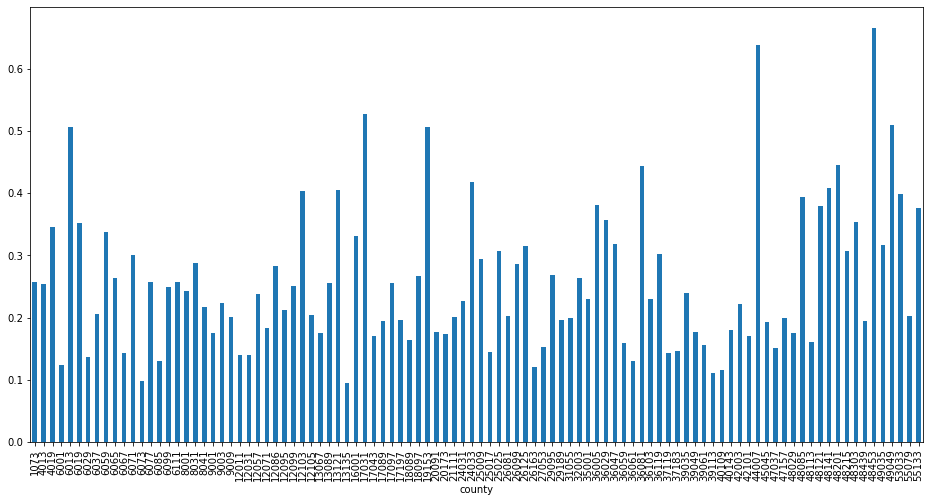

In [345]:
res.groupby('county')['loss'].mean().plot(kind='bar', figsize=(16,8))

<AxesSubplot:xlabel='date'>

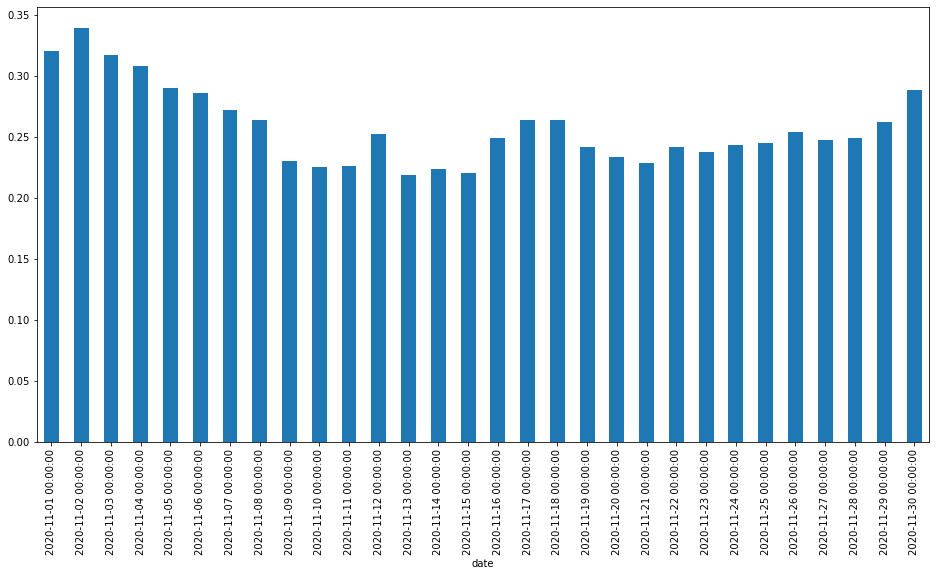

In [346]:
res.groupby('date')['loss'].mean().plot(kind='bar', figsize=(16,8))